## Classification using 1 hidden layer

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline
np.random.seed(1)

### Get the dataset

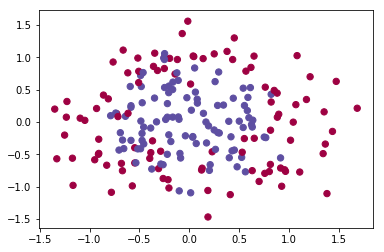

In [14]:
def load_dataset():  
    N = 200
    make_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    return make_circles

X, Y = load_dataset()
X, Y = X.T, Y.reshape(1, Y.shape[0])
# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Dataset contains:
    - a numpy-array (matrix) X 
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

In [16]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size
print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 200)
The shape of Y is: (1, 200)
I have m = 200 training examples!


## Using Simple Logistic Regression

Before building a full neural network, first see how logistic regression performs on this problem. 

In [17]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

Accuracy of logistic regression: 51 % (percentage of correctly labelled datapoints)


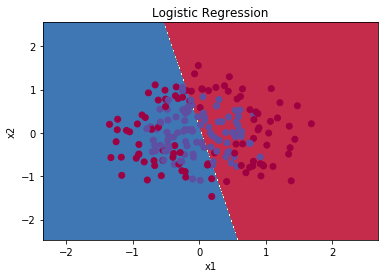

In [18]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

The dataset is not linearly separable, so logistic regression doesn't perform well.

#### Neural Network model
##### Defining the neural network structure

In [19]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

##### Initialize the model's parameters

In [21]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    W1 = np.random.randn(n_h,n_x) *0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

#### Implement `forward_propagation()`.


In [23]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) +b2
    A2 = sigmoid(Z2)
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

Using $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, compute the cost function

In [25]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    m = Y.shape[1] # number of example
    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),1-Y)
    cost = -1/m * np.sum(logprobs)
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    return cost

Using the cache computed during forward propagation, implement backward propagation.

In [27]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2 ,axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1-np.power(A1,2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
       
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.



In [29]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    # Update rule for each parameter
    W1 = W1 -(learning_rate * dW1)
    b1 = b1 -(learning_rate * db1)
    W2 = W2 -(learning_rate * dW2)
    b2 = b2 -(learning_rate * db2)
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Integrate functions above in right order in nn_model() ####

In [31]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X,parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2,Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters,cache,X,Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

##### Predictions

Use the model to predict. 

In [33]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X,parameters)
    predictions = (A2 > 0.5)
    
    return predictions

Test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693155
Cost after iteration 1000: 0.374405
Cost after iteration 2000: 0.370295
Cost after iteration 3000: 0.374859
Cost after iteration 4000: 0.367748
Cost after iteration 5000: 0.368698
Cost after iteration 6000: 0.370769
Cost after iteration 7000: 0.367406
Cost after iteration 8000: 0.367855
Cost after iteration 9000: 0.368825


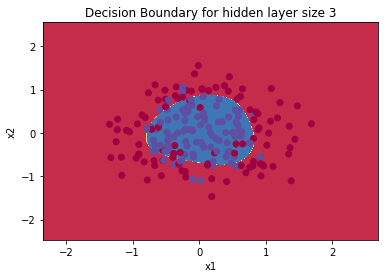

In [43]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 3, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(3))

In [41]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 84%


Accuracy is really high compared to Logistic Regression. Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 
Try out several hidden layer sizes.

#### Tuning hidden layer size
Observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 62.5 %
Accuracy for 2 hidden units: 72.5 %
Accuracy for 3 hidden units: 84.0 %
Accuracy for 4 hidden units: 83.0 %
Accuracy for 5 hidden units: 84.0 %
Accuracy for 20 hidden units: 79.5 %
Accuracy for 50 hidden units: 83.5 %


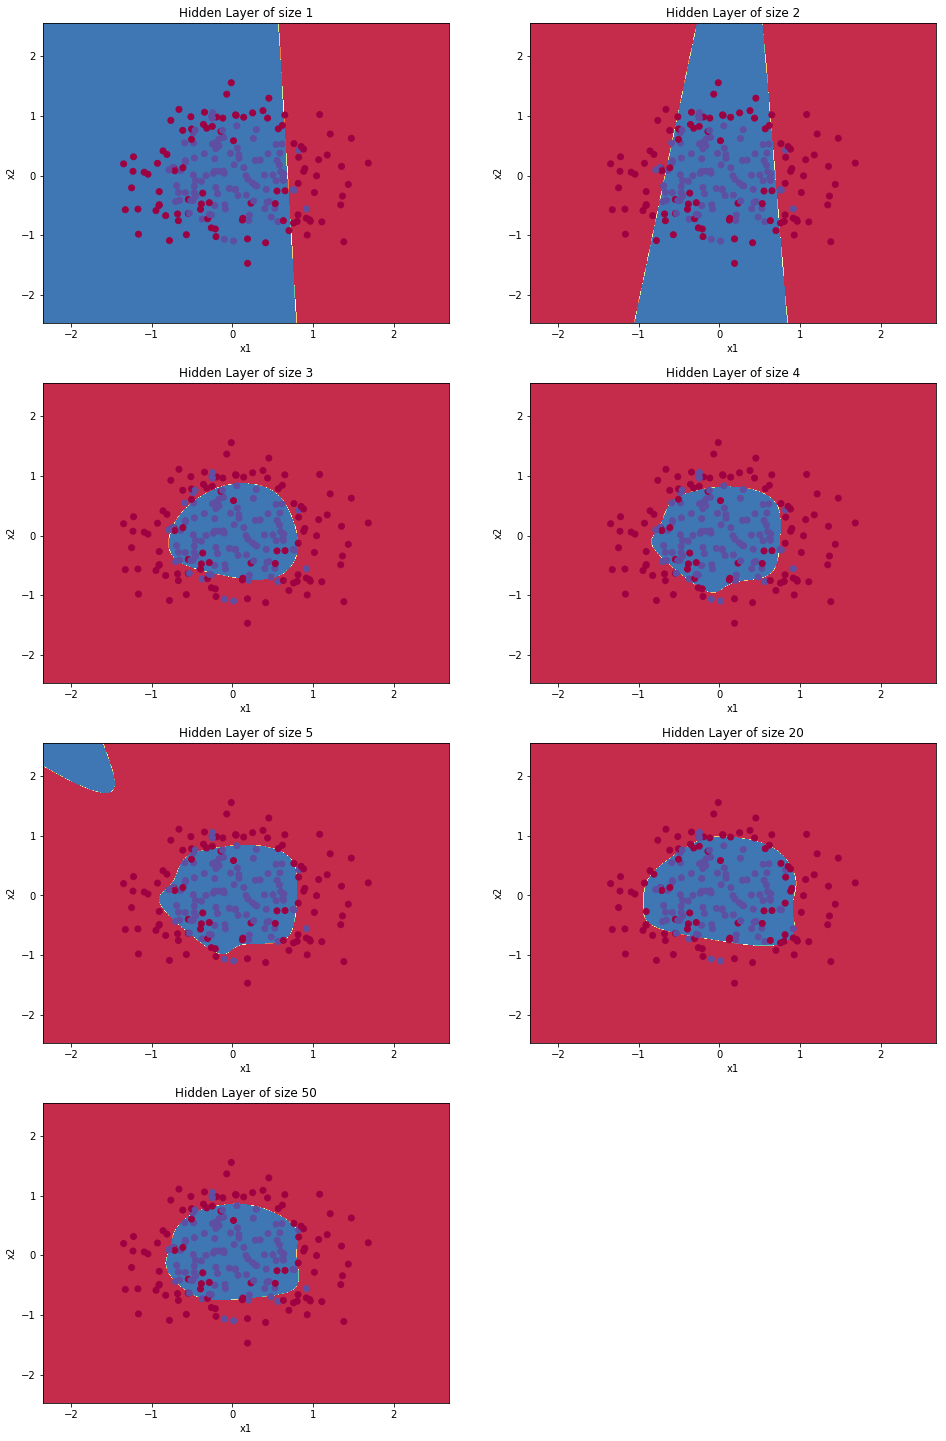

In [42]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))